In [3]:
import numpy as np
import qiskit as qk
import qiskit_aer as aer
import qutip as qt
import numpy.linalg as la
from scipy.linalg import expm

In [4]:
N = 3
def linear(t, T):
    return t/T

In [5]:
def adiabatic(circ, h0, ht, tf, steps, lmb): #circuit, initial H, target H, time final
    dt = tf / steps
    for i in range(steps):
        #print(h0, ht)
        if not isinstance(h0, np.ndarray):
            h0 = h0.full()
        if not isinstance(ht, np.ndarray):
            ht = ht.full()
        h = (1 - lmb(dt * i, tf)) * h0 + lmb(dt * i, tf) * ht
        u = qk.quantum_info.Operator(expm(-1.j * h / steps * dt))
        circ.append(u, circ.qubits)
    return circ

In [6]:
si = qt.qeye(2)
sx = qt.sigmax()

sxs = []
for n in range(N):
    ops = N * [si]
    ops[n] = sx
    sxs.append(qt.tensor(ops))

In [7]:
h0 = sum(mat.full() for mat in sxs)
eigs = la.eig(h0)
print(la.eig(h0))

EigResult(eigenvalues=array([ 3.+0.j, -3.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j,
       -1.+0.j]), eigenvectors=array([[ 0.35355339+0.j,  0.35355339-0.j,  0.52950338+0.j,
         0.59041351+0.j, -0.11790518+0.j, -0.13101392+0.j,
        -0.20145238+0.j, -0.00161615+0.j],
       [ 0.35355339+0.j, -0.35355339+0.j, -0.02857465+0.j,
        -0.3051494 +0.j, -0.36130801+0.j, -0.57520229+0.j,
         0.01893366-0.j, -0.43012638+0.j],
       [ 0.35355339+0.j, -0.35355339+0.j,  0.45663985+0.j,
        -0.04880263+0.j,  0.58654481+0.j,  0.05880604-0.j,
         0.35605447-0.j, -0.11713615+0.j],
       [ 0.35355339+0.j,  0.35355339+0.j, -0.10143818+0.j,
        -0.23646149+0.j, -0.10733161+0.j, -0.38538232+0.j,
         0.57644052+0.j,  0.54887868+0.j],
       [ 0.35355339+0.j, -0.35355339+0.j,  0.10143818+0.j,
        -0.23646149+0.j, -0.10733161+0.j,  0.38538232-0.j,
        -0.57644052+0.j,  0.54887868-0.j],
       [ 0.35355339+0.j,  0.35355339-0.j, -0.45663985+0.j,
        -0.04

In [8]:
ind = 0
for i in range(len(eigs[0])):
    if eigs[0][i].real < eigs[0][ind].real:
        ind = i

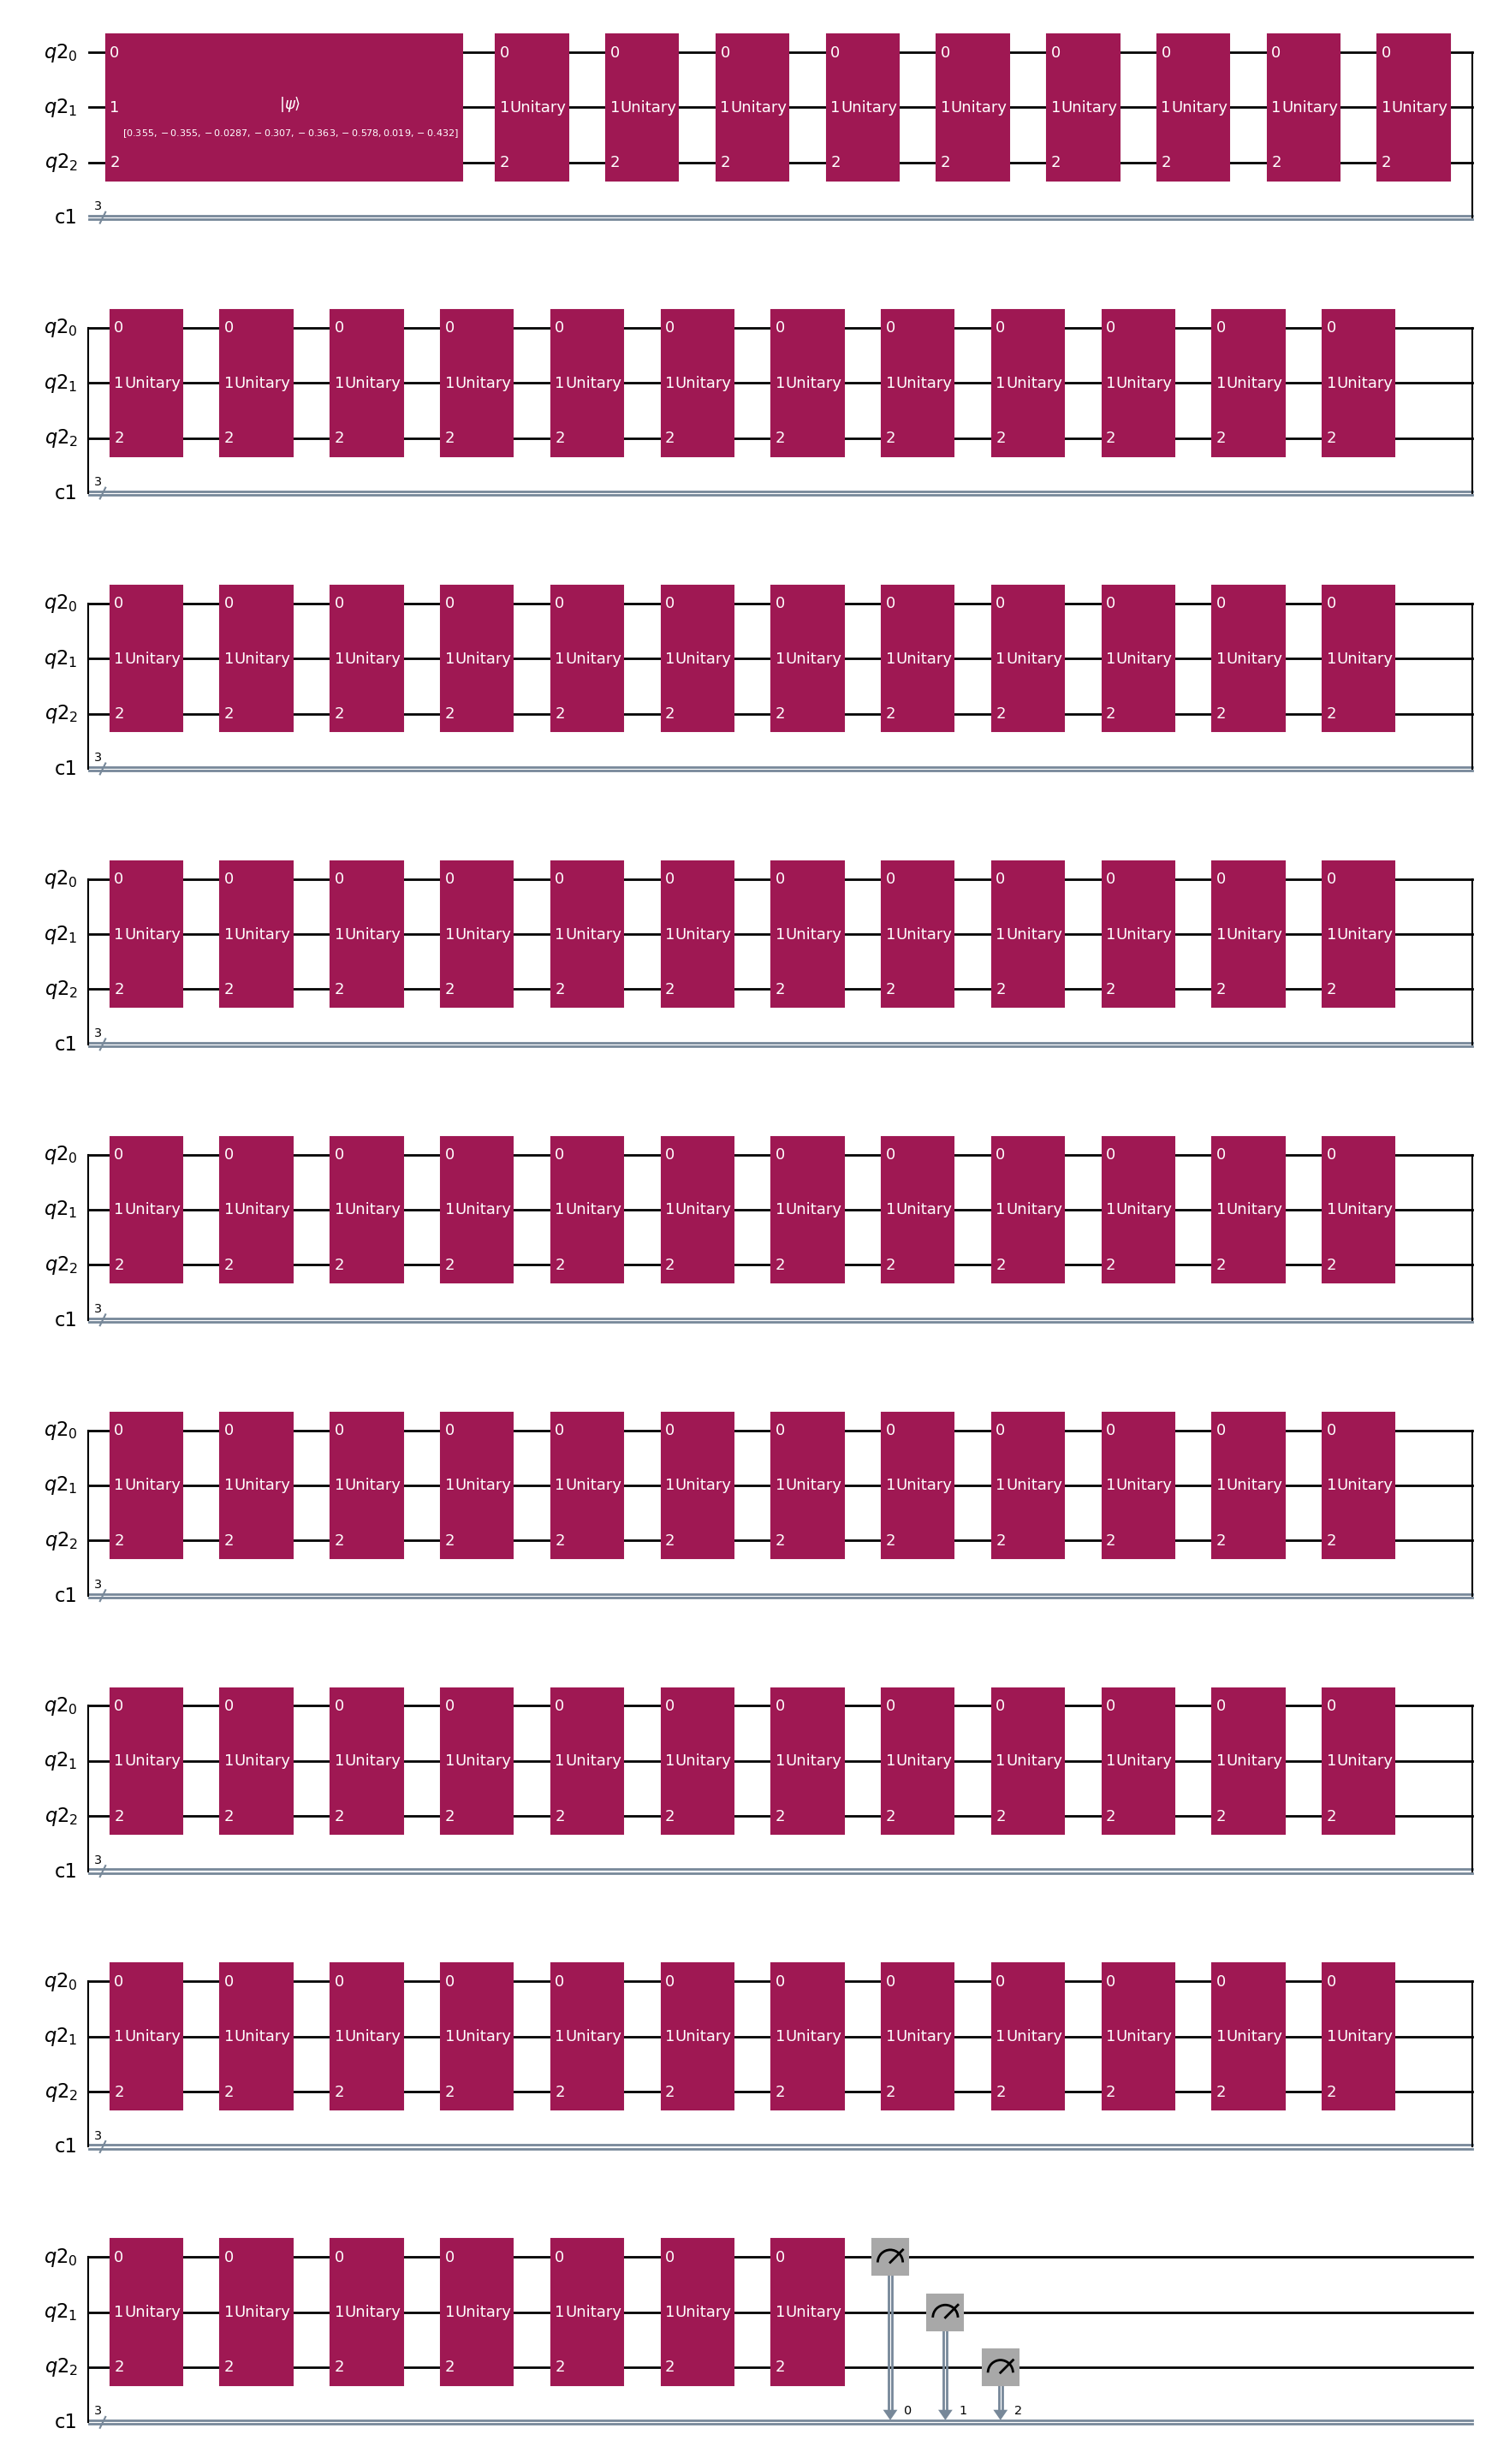

In [12]:
qr = qk.QuantumRegister(N)
cr = qk.ClassicalRegister(N)
circ = qk.QuantumCircuit(qr, cr)
#create target hamiltonian
si = qt.qeye(2)
sz = qt.sigmaz()

szs = []
for n in range(N):
    ops = N * [si]
    ops[n] = sz
    szs.append(qt.tensor(ops))
ht = -1 * szs[0] * szs[1] - 0.5 * szs[1] * szs[2] - sxs[0] - 1.5 * sxs[2]

#find some h0 hamiltonian and establish psi0 state.
ground_state = eigs[1][ind] 
norm = la.norm(ground_state)
ground_state = 1/norm * ground_state
init_gate = qk.circuit.library.Initialize(ground_state)
circ.append(init_gate, circ.qubits)

#apply adiabatic algorithm
circ = adiabatic(circ, h0, ht, 2, 100, linear)

#measure
circ.measure(qr, cr)
circ.draw('mpl')


In [13]:
simulator = aer.AerSimulator()
num_shots = 10000
job = simulator.run(circ, shots = num_shots)
results = job.result()
counts = results.get_counts()

In [14]:
counts

{'101': 3316,
 '011': 976,
 '100': 1292,
 '001': 1274,
 '111': 1856,
 '000': 1269,
 '010': 10,
 '110': 7}

In [15]:
basis_states = []
basis_states.append(['0', '1'])
for i in range(2):
    new = []
    for b in basis_states[i]:
        new.append('0' + b)
        new.append('1' + b)
    basis_states.append(new)
print(basis_states)

[['0', '1'], ['00', '10', '01', '11'], ['000', '100', '010', '110', '001', '101', '011', '111']]


In [16]:
final_state = np.array([np.sqrt(counts.get(i, 0)/num_shots) for i in basis_states[2]])
final_state

array([0.35623026, 0.35944402, 0.03162278, 0.02645751, 0.35693137,
       0.5758472 , 0.31240999, 0.43081318])

In [17]:
final_state.reshape((1, 8))

array([[0.35623026, 0.35944402, 0.03162278, 0.02645751, 0.35693137,
        0.5758472 , 0.31240999, 0.43081318]])

In [18]:
sum(i ** 2 for i in final_state)

1.0

In [19]:
mult = ht.full() @ final_state.reshape(-1, 1)
mult

array([[-1.43044278+0.j],
       [-1.2899146 +0.j],
       [-0.30466209+0.j],
       [-0.46501859+0.j],
       [-1.04153538+0.j],
       [-0.03107026+0.j],
       [-0.83404755+0.j],
       [-1.14129227+0.j]])

In [20]:
mult.flatten() / final_state

array([ -4.01550046+0.j,  -3.58863842+0.j,  -9.63426127+0.j,
       -17.57605074+0.j,  -2.91802705+0.j,  -0.05395574+0.j,
        -2.66972114+0.j,  -2.64915818+0.j])

In [21]:
ht

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-1.5 -1.5  0.   0.  -1.   0.   0.   0. ]
 [-1.5 -0.5  0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   1.5 -1.5  0.   0.  -1.   0. ]
 [ 0.   0.  -1.5  0.5  0.   0.   0.  -1. ]
 [-1.   0.   0.   0.   0.5 -1.5  0.   0. ]
 [ 0.  -1.   0.   0.  -1.5  1.5  0.   0. ]
 [ 0.   0.  -1.   0.   0.   0.  -0.5 -1.5]
 [ 0.   0.   0.  -1.   0.   0.  -1.5 -1.5]]

In [22]:
la.eig(ht)

EigResult(eigenvalues=array([-2.99535239+0.j,  2.99535239+0.j,  0.16692527+0.j, -0.16692527+0.j,
        2.99535239+0.j, -2.99535239+0.j, -0.16692527+0.j,  0.16692527+0.j]), eigenvectors=array([[ 7.49490051e-01+0.j,  2.23758939e-01-0.j, -5.40201864e-01+0.j,
        -3.10448944e-01+0.j,  8.77596904e-04-0.j, -9.10771963e-04+0.j,
        -2.02345697e-01+0.j,  6.99740604e-02-0.j],
       [ 5.40201864e-01+0.j, -3.10448944e-01+0.j,  7.49490051e-01+0.j,
        -2.23758939e-01+0.j, -1.21760066e-03+0.j, -6.56447290e-04+0.j,
        -1.45842526e-01+0.j, -9.70838229e-02+0.j],
       [ 2.89725167e-18+0.j, -9.70446728e-18+0.j, -7.21309839e-17+0.j,
         1.25512722e-16-0.j,  7.49484286e-01+0.j,  2.23758773e-01-0.j,
         4.09691544e-01-0.j,  3.07833439e-01-0.j],
       [ 3.50338993e-18+0.j, -1.17347531e-17+0.j, -8.72216126e-17+0.j,
         1.51771422e-16-0.j, -5.40197710e-01+0.j,  3.10448715e-01-0.j,
         5.68416654e-01+0.j, -2.21873790e-01+0.j],
       [ 3.10448944e-01+0.j, -5.40201864e